# Simulating
This can be done many differet ways from statistical models informed based on the team/player performance or simple models which focus on specific attributes or are random simulators.  

---
To get started, a simple model will be leveraged to simulate a football match. One in which goals occur completely at random during the match.

In [1]:
import numpy as np
import numpy.random as rnd
import pandas as pd
import time
import pylab as plt
import sketch

### Setting parameters for the simplified model
Set up the basic scoring rates for football and other contoling aspects of a game. 

In [2]:
# Length of match
match_minutes = 90
# Average goals per match
goals_per_match = 2.79
# Probability of a goal per minute
prob_per_minute = np.array(goals_per_match/match_minutes)
print(f'The probability of a goal per minute is {prob_per_minute:.5f}\n' )

The probability of a goal per minute is 0.03100



### Simulating a single game
To simulate a single game, Goals go in with the same probability every minute. Run the simulation below 10 times. How many times were there 3 goals in a match?

In [3]:
def sim_match(match_minutes:int=90, show:bool=False, ):
    '''Simulate a soccer match without stipulating team details'''
    
    #Count of the number of goals
    goals=0

    for minute in range(match_minutes):
        r=rnd.rand(1,1) # Generate a random number between 0 and 1.
        
        # Prints an X when there is a goal and a zero otherwise.
        if (r < prob_per_minute): 
            if show:
                print('X', end = ' ') #Goal - if the random number is less than the goal probability.
                time.sleep(0.3)  #Longer pause
            goals+=1
            
        else:
            if show:
                print('o', end = ' ')
                time.sleep(0.1)  #Short pause

    if show:
        print('Final whistle. \n \nThere were ' + str(goals) + ' goals.')
    return goals

In [4]:
sim_match(show=True)

o o 

o o o o o X o o o o o o o o o X o o o o o o o o o o o X o X o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o X o o X o o o o o o Final whistle. 
 
There were 6 goals.


6

           Goals
count  10.000000
mean    3.400000
std     1.646545
min     1.000000
25%     2.250000
50%     3.000000
75%     4.000000
max     6.000000


Text(0.5, 1.0, 'Goals per match simulated')

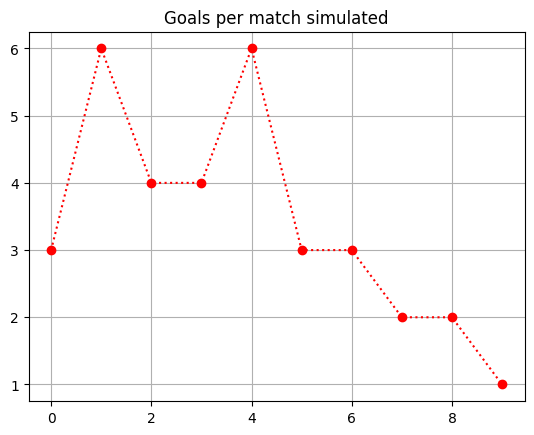

In [5]:
G=pd.DataFrame([sim_match() for i in range(10)], columns=['Goals'])

print(G.describe())
fig, ax = plt.subplots()
G.Goals.plot(style='r:o', ax=ax)
ax.grid(True)
ax.set_title('Goals per match simulated')

### Simulating goals over a season
Now there is a need to shift to an entire season. This requires 380 games to be played accounting for the Fall and Spring of a professional campaign.  To accomplish this the code for the single match is extended and modified to simulate the games and store the results in an array.

1. Define new simulateMatch function 
2. Loop over 380 matches
3. Store the number of goals for each match in an array 
4. Create a histogram of the number of goals

In [6]:
def simulateMatch(n:int=90, p:float=0.03100):
    '''
    Simulate a football match
    
    n - number of time units
    p - probability per time unit of a goal
    display_match == True then display simulation output for match.

    Return array with Count of the number of goals per match across the season'''
    
    goals = 0
    for minute in range(n): 
        r = rnd.rand(1, 1) # Generate a random number between 0 and 1.
        if (r < p):
            goals += 1 # Incrament Goal - if the random number is less than the goal probability.
            
    return goals

In [7]:
# Choose a Number of matches
num_matches = 380

# Loop over all the matches return goals storing the value in initialized numpy array.
goals = np.zeros(num_matches)
for i in range(num_matches):
    goals[i] = simulateMatch(match_minutes, prob_per_minute) # stores value at match index for range

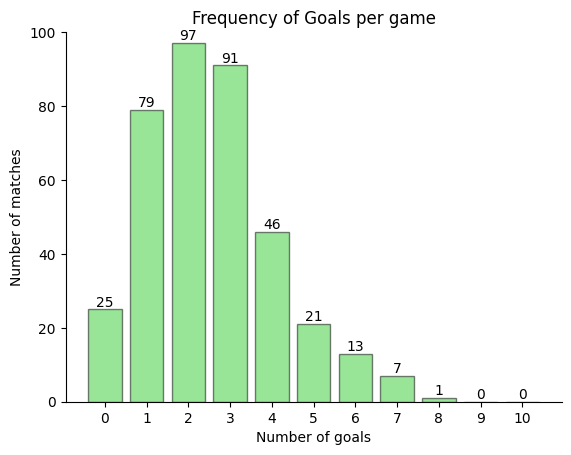

In [8]:
# Create a histogram

fig, ax = plt.subplots(num=1)

histogram_range = np.arange(-0.5, 10.51, 1)
histogram_goals = np.histogram(goals, histogram_range)

p = ax.bar(histogram_goals[1][:-1] + 0.5, histogram_goals[0], color='limegreen', edgecolor='black', linestyle='-', alpha=0.5)
ax.set_ylim(0, 100)
ax.bar_label(p)
ax.spines[['top','right']].set_visible(False)
ax.set_xticks(np.arange(0, 11, step=1))
ax.set_yticks(np.arange(0, 101, step=20))
ax.set_xlabel('Number of goals')
ax.set_ylabel('Number of matches')
ax.set_title('Frequency of Goals per game')
plt.show()

### Simulating results
Use a Poisson regression to fit a model to the Premier League and then we use the estimated values to simulate results between two teams.

This code is adapted from this [artical](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/)

In [9]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import poisson,skellam

#### Import data
Data taken from football-data.co.uk

In [10]:
epl = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/E0.csv")
ep = (epl[['HomeTeam','AwayTeam','FTHG','FTAG']]
      .rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
     )

In [11]:
epl = (epl
       .rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
       [:-10]
      )
       
epl.mean(numeric_only=True)

HomeGoals     1.491892
AwayGoals     1.297297
HTHG          0.686486
HTAG          0.586486
HS           13.764865
               ...    
PCAHA         1.976486
MaxCAHH       2.019946
MaxCAHA       2.054649
AvgCAHH       1.925973
AvgCAHA       1.959514
Length: 98, dtype: float64

### Perform the regression
In the fit, include a parameter for home advantage. Team and opponent are fixed effects.

In [12]:
goal_model_data = (pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']]
                              .assign(home=1)
                              .rename(columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
                             epl[['AwayTeam','HomeTeam','AwayGoals']]
                              .assign(home=0)
                              .rename(columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])
                  )

In [13]:
goal_model_data.head(3)

,team,opponent,goals,home
0,Brentford,Arsenal,2,1
1,Man United,Leeds,5,1
2,Burnley,Brighton,1,1


In [14]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data,
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1043.1
Date:                Fri, 29 Sep 2023   Deviance:                       776.72
Time:                        22:32:33   Pearson chi2:                     681.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2498
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2470      0.203      1.214      0.225      -0.152       0.646
team[T.Aston Villa]           -0.1298      0.195     -0.666      0.506      -0.512       0.252
team[T.Brentford]             -0.1589      0.198     -0.802      0.423      -0.547       0.230
team[T.Brighton]              -0.3735      0.209     -1.788      0.074      -0.783       0.036
team[T.Burnley]               -0.5263      0.220     -2.395      0.017      -0.957      -0.096
team[T.Chelsea]                0.2714      0.177      1.529      0.126      -0.077       0.619
team[T.Crystal Palace]        -0.1370      0.196     -0.699      0.484      -0.521       0.247
team[T.Everton]               -0.2847      0.204     -1.394      0.163      -0.685       0.116
team[T.Leeds]                 -0.3127      0.207     -1.507      0.132      -0.719       0.094
team[T.Leicester]              0.0481      0.188      0.256      0.798      -0.320       0.416
team[T.Liverpool]              0.4522      0.170      2.657      0.008       0.119       0.786
team[T.Man City]               0.5115      0.168      3.036      0.002       0.181       0.842
team[T.Man United]             0.0156      0.189      0.083      0.934      -0.354       0.385
team[T.Newcastle]             -0.2841      0.204     -1.389      0.165      -0.685       0.117
team[T.Norwich]               -0.8697      0.248     -3.507      0.000      -1.356      -0.384
team[T.Southampton]           -0.2770      0.205     -1.354      0.176      -0.678       0.124
team[T.Tottenham]              0.1294      0.183      0.706      0.480      -0.230       0.489
team[T.Watford]               -0.5181      0.220     -2.357      0.018      -0.949      -0.087
team[T.West Ham]               0.0398      0.187      0.213      0.831      -0.327       0.406
team[T.Wolves]                -0.4429      0.212     -2.088      0.037      -0.859      -0.027
opponent[T.Aston Villa]        0.1071      0.203      0.529      0.597      -0.290       0.504
opponent[T.Brentford]          0.1297      0.200      0.649      0.516      -0.262       0.521
opponent[T.Brighton]          -0.0994      0.211     -0.470      0.638      -0.514       0.315
opponent[T.Burnley]            0.0579      0.202      0.286      0.775      -0.339       0.455
opponent[T.Chelsea]           -0.3702      0.230     -1.613      0.107      -0.820       0.080
opponent[T.Crystal Palace]    -0.0219      0.208     -0.105      0.916      -0.429       0.385
opponent[T.Everton]            0.2573      0.194      1.325      0.185      -0.123       0.638
opponent[T.Leeds]              0.4973      0.185      2.688      0.007       0.135       0.860
opponent[T.Leicester]          0.2134      0.197      1.085      0.278      -0.172       0.599
opponent[T.Liverpool]         -0.6001      

### Simulating a game
Simulate a match between Manchester City and Arsenal.  This will leverage the poission model to simulate a score rate for each team, and the outcome of a match between the two.  This will be followed by a simulation of the probability of all likely score lines between the two teams.

In [15]:
# Set teams
home_team='Tottenham'
away_team='Arsenal'

In [16]:
# Predict for Arsenal vs. Tottenham home and away series
home_score_rate=poisson_model.predict(pd.DataFrame(data={'team': home_team, 'opponent': away_team,
                                       'home':1},index=[1]))
away_score_rate=poisson_model.predict(pd.DataFrame(data={'team': away_team, 'opponent': home_team,
                                       'home':0},index=[1]))
print(f'{home_team} against {away_team} expect to score: ' + str(home_score_rate))
print(f'{away_team} against {home_team} expect to score: ' + str(away_score_rate))

Tottenham against Arsenal expect to score: 1    1.693137
dtype: float64
Arsenal against Tottenham expect to score: 1    1.090481
dtype: float64


In [17]:
# Simulate a direct result
home_goals=np.random.poisson(home_score_rate)
away_goals=np.random.poisson(away_score_rate)
print(home_team + ': ' + str(home_goals[0]))
print(away_team + ': '  + str(away_goals[0]))

Tottenham: 1
Arsenal: 1


>**NOTE**: Sometimes big match ups do not result in goals

### Two-dimensional histogram of scores
This provides the probability of multiple score lines between the two teams in question, home and away.  The simulation is run with a max goal limit set to a default of 10 which limits outcomes, but this will be defined at the time of simulation.  

In [18]:
# Function to caluclate the goals for the match.
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    '''Function which determines average goals for the home and away teams, and then uses the average
    to simulate the outcome of a game
    foot_model = predictive model developed ahead of simulation
    homeTeam/awayTeam = string entry for team names
    max_goals = integer goal limit for simulation'''
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam,'opponent': awayTeam, 'home': 1},
                                                     index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam,'opponent': homeTeam, 'home': 0},
                                                     index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals + 1)] for team_avg in
                 [home_goals_avg, away_goals_avg]]
    return (np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

In [19]:
#Fill in the matrix
max_goals=5
score_matrix=simulate_match(poisson_model, home_team, away_team,max_goals)

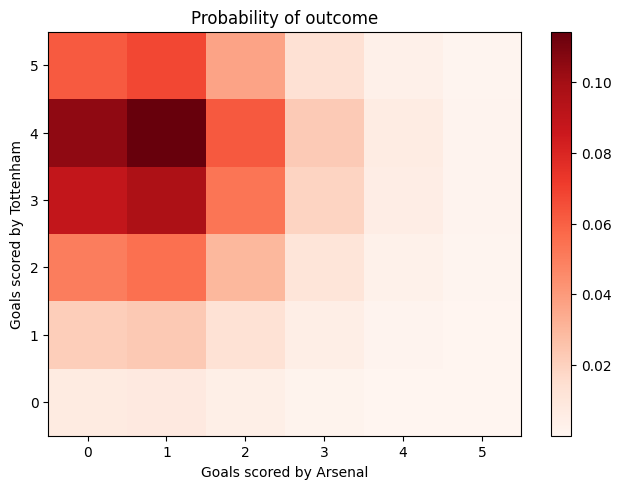

In [20]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
pos=ax.imshow(score_matrix, extent=[-0.5,max_goals+0.5,-0.5,max_goals+0.5], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of outcome')
plt.xlim((-0.5,5.5))
plt.ylim((-0.5,5.5))
plt.tight_layout()
ax.set_xlabel('Goals scored by ' + away_team)
ax.set_ylabel('Goals scored by ' + home_team)
plt.show()

# Home, draw, away probabilities
homewin=np.sum(np.tril(score_matrix, -1))
draw=np.sum(np.diag(score_matrix))
awaywin=np.sum(np.triu(score_matrix, 1))

### Statistical modelling
In this section a variety of methods is considered for evaluating the degree to which passing/possession lead to goals being scroed, and how to identify the strongest areas on the pitch for a team.  These are two very specific methodologies being considered; Ball movement vs positioning.  Each has its place to improve the team's chances for success.

In [21]:
#importing necessary libraries
from mplsoccer import Sbopen, Pitch
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import colors

#open data from WWC 2019
parser = Sbopen()
df_match = parser.match(competition_id=72, season_id=30)

In [22]:
df_match.head(3)

,match_id,match_date,kick_off,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,...,competition_stage_id,competition_stage_name,stadium_id,stadium_name,stadium_country_id,stadium_country_name,referee_id,referee_name,referee_country_id,referee_country_name
0,22949,2019-06-12,2019-06-12 18:00:00,1,0,available,scheduled,2023-07-24 21:46:41.279089,2021-06-13 16:17:31.694,2,...,1,Regular Season,231,Stade du Hainaut,78,France,374.0,Kateryna Monzul,238.0,Ukraine
1,22943,2019-06-11,2019-06-11 21:00:00,13,0,available,scheduled,2023-07-24 21:45:44.511885,2021-06-13 16:17:31.694,1,...,1,Regular Season,232,Stade Auguste-Delaune II,78,France,NaN,NaN,NaN,NaN
2,22944,2019-06-11,2019-06-11 18:00:00,0,2,available,scheduled,2023-07-25 05:54:25.449812,2021-06-13 16:17:31.694,1,...,1,Regular Season,166,Roazhon Park,78,France,1638.0,Lucila Venegas Montes,147.0,Mexico


In [23]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   match_id                         52 non-null     int64         
 1   match_date                       52 non-null     datetime64[ns]
 2   kick_off                         52 non-null     datetime64[ns]
 3   home_score                       52 non-null     int64         
 4   away_score                       52 non-null     int64         
 5   match_status                     52 non-null     object        
 6   match_status_360                 52 non-null     object        
 7   last_updated                     52 non-null     datetime64[ns]
 8   last_updated_360                 52 non-null     datetime64[ns]
 9   match_week                       52 non-null     int64         
 10  competition_id                   52 non-null     int64         


### Data Prep
Two different dataframes are required for the analysis. 
- **passshot_df:** This dataframe will keep information about team performance in every game they played - index of a game, name of a team, number of shots, number of goals and number of danger passes by this team (see Danger passes). 
- **danger_passes_df:** Dataframe of all danger passes during the tournament. 

In [24]:
# get team names
teams = df_match["home_team_name"].unique()

# get indicies of all games
match_ids = df_match["match_id"]

In [25]:
# Initialize empty dataframes
# passshot_df = pd.DataFrame()
# danger_passes_df = pd.DataFrame()

## REFACTOR CODE

In [26]:
#for every game in the tournament
def get_home_away(match_ids):
    '''Create dataframe for passshot_df and danger_passes_df from season data'''
    passshot_df = pd.DataFrame()
    danger_passes_df = pd.DataFrame()

    for idx in match_ids:
        # open event data
        df = parser.event(idx)[0]
        # get home and away team
        home_team = df_match.loc[lambda df_: df_.match_id == idx]["home_team_name"].iloc[0]
        away_team = df_match.loc[lambda df_: df_.match_id == idx]["away_team_name"].iloc[0]
        return home_team, away_team

def get_pass_shot_danger_pass(teams:list, df):
    for team in teams:
        # declare count variables to sum shots, passes and danger passes from both halves
        shots = 0
        passes = 0
        danger_passes = 0
        
        #for both periods - see previous lessons
        for period in [1, 2]:
            # passes
            mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
            pass_df = df.loc[mask_pass]
            
            # A dataframe of shots ## Find passes within 15 seconds of a shot, exclude corners.
            shot_window = 15
            mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
            shot_df = df.loc[mask_shot, ["minute", "second"]]
            shot_times = shot_df['minute']*60+shot_df['second'] # convert time to seconds
            

            # find start of the window ## add condition to avoid negative shot starts
            shot_start = shot_times - shot_window
            shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45) 
            pass_times = pass_df['minute']*60+pass_df['second']
            
            # check if pass is in any of the windows for this half
            pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())
            danger_passes_period = pass_df.loc[pass_to_shot]

            #will need later all danger passes
            danger_passes_df = pd.concat([danger_passes_df, danger_passes_period], ignore_index = True)

            #adding number of passes, shots and danger passes from a game
            passes += len(pass_df)
            shots += len(shot_df)
            danger_passes += len(danger_passes_period)
        #getting number of goals by the team from the game
        if team == home_team:
            goals = df_match.loc[df_match["match_id"] == idx]["home_score"].iloc[0]
        else:
            goals = df_match.loc[df_match["match_id"] == idx]["away_score"].iloc[0]
        #appending passshot dataframe
        match_info_df = pd.DataFrame({
                    "Team": [team],
                    "Passes": [passes],
                    "Shots": [shots],
                    "Goals": [goals],
                    "Danger Passes": [danger_passes]
                    })
        passshot_df = pd.concat([passshot_df, match_info_df])